In [1]:
import sys

sys.path.append("..")

import critical_loads as cl
import nivapy3 as nivapy
import numpy as np
import pandas as pd
from osgeo import gdal

In [2]:
# Connect to PostGIS
eng = nivapy.da.connect_postgis(database="critical_loads")

Connection successful.


# Soils workflow

See e-mail from Kari received 24.05.2023.

> We have previously calculated exceedances also for forest soils, but I cannot see that you made this output this time? I suppose the exceedance would still be zero, but I think we should still calculate it. For all the periods and dep data for which we calculated the other exceedances. Can you do this? 

Based on the notebook [here](https://github.com/JamesSample/critical_loads_2/blob/master/notebooks/05_soil_new_grid.ipynb), and assuming the original soil CLs haven't changed, this notebook uses the updated deposition data to calculate soil exceedances.

In [3]:
# User options
cell_size = 120

# Series to use
series_dict = {
    1: ("7882", 1978, 1982),
    29: ("8387", 1983, 1987),
    30: ("8892", 1988, 1992),
    2: ("9296", 1992, 1996),
    3: ("9701", 1997, 2001),
    4: ("0206", 2002, 2006),
    25: ("0711", 2007, 2011),
    26: ("1216_old", 2012, 2016),
    66: ("1721_old", 2017, 2021),
    67: ("1721_blrgrid", 2017, 2021),
    -1: ("1721_metgrid", 2017, 2021),
}

Processing 1978 to 1982
Processing 1983 to 1987
Processing 1988 to 1992
Processing 1992 to 1996
Processing 1997 to 2001
Processing 2002 to 2006
Processing 2007 to 2011
Processing 2012 to 2016
Processing 2017 to 2021
Processing 2017 to 2021
Processing 2017 to 2021


,series_id,total_area_km2,exceeded_area_km2,exceeded_area_pct,medium,short_name
0,1,108683,1379,1,soil,7882
0,29,108683,1848,2,soil,8387
0,30,108683,796,1,soil,8892
0,2,108683,199,0,soil,9296
0,3,108683,0,0,soil,9701
0,4,108683,0,0,soil,0206
0,25,108683,0,0,soil,0711
0,26,108683,0,0,soil,1216_old
0,66,108683,0,0,soil,1721_old
0,67,108683,0,0,soil,1721_blrgrid


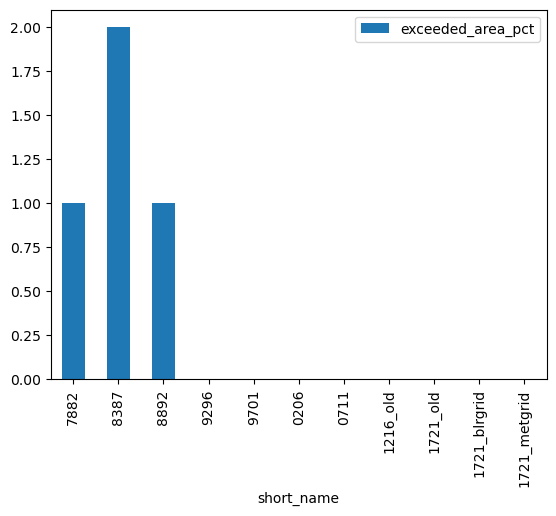

In [4]:
# Soil CL raster
cl_tif = f"/home/jovyan/shared/critical_loads/raster/soil_cl_mgspm2pyr_{cell_size}m.tif"

# Snap raster
snap_tif = f"/home/jovyan/shared/critical_loads/raster/sat_veg_{cell_size}m_norut.tif"

df_list = []
for ser_id, period in series_dict.items():
    short_name = period[0]
    st_per = period[1]
    end_per = period[2]
    print(f"Processing {st_per} to {end_per}")

    sdep_tif = f"/home/jovyan/shared/critical_loads/raster/deposition/sdep_mgpm2pyr_{short_name}_{cell_size}m.tif"
    ex_tif = f"/home/jovyan/shared/critical_loads/raster/exceedance/{short_name}/soil_ex_mgpm2pyr_{short_name}_{cell_size}m.tif"

    # Read tifs
    dep_s, ndv, epsg, extent = nivapy.spatial.read_raster(sdep_tif)
    dep_s = dep_s.astype(np.float32)
    dep_s[dep_s == ndv] = np.nan

    cl_soil, ndv, epsg, extent = nivapy.spatial.read_raster(cl_tif)
    cl_soil = cl_soil.astype(np.float32)
    cl_soil[cl_soil == ndv] = np.nan

    # Exceedance
    ex_soil = dep_s - cl_soil
    ex_soil[ex_soil < 0] = 0

    # Get exceeded area
    ex_area = np.count_nonzero(ex_soil > 0) * cell_size * cell_size / 1.0e6
    nor_area = np.count_nonzero(~np.isnan(ex_soil)) * cell_size * cell_size / 1.0e6
    ex_pct = 100 * ex_area / nor_area

    ex_df = pd.DataFrame(
        {
            "series_id": ser_id,
            "total_area_km2": nor_area,
            "exceeded_area_km2": ex_area,
            "exceeded_area_pct": ex_pct,
        },
        index=[0],
    )
    ex_df = ex_df.round(0).astype(int)
    ex_df["medium"] = "soil"
    ex_df["short_name"] = short_name

    # Set NaN to -1
    ex_soil[np.isnan(ex_soil)] = -1

    # Save geotiff
    cl.write_geotiff(ex_soil, ex_tif, snap_tif, -1, gdal.GDT_Int16)

    ex_df["short_name"] = short_name
    df_list.append(ex_df)
ex_df = pd.concat(df_list, axis="rows")
ex_df.plot.bar(x="short_name", y="exceeded_area_pct")
ex_df